In [21]:
import pandas as pd

column_names = ['datetime', 'pH']  
ph_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/ph_log_2025-04-15_18-21-10.csv', header=None, names=column_names)
ph_dataset['unixtime'] = pd.to_datetime(ph_dataset['datetime']).astype('int64') // 10**9

In [22]:
column_names = ['datetime', 'dO'] 
do_dataset_1 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-16_10-15-56.csv', header=None, names=column_names)
do_dataset_1['unixtime'] = pd.to_datetime(do_dataset_1['datetime']).astype('int64') // 10**9

do_dataset_2 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-15_18-20-45.csv', header=None, names=column_names)
do_dataset_2['unixtime'] = pd.to_datetime(do_dataset_2['datetime']).astype('int64') // 10**9

merged = pd.merge(do_dataset_1, do_dataset_2, on='unixtime', how='outer', suffixes=('_1', '_2'))
merged['datetime'] = merged['datetime_1'].combine_first(merged['datetime_2'])
merged['dO'] = merged['dO_1'].combine_first(merged['dO_2'])
merged_do_dataset = merged[['unixtime', 'datetime', 'dO']]

In [23]:
column_names = ['date', 'time', 'temperature (C)']
temp_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/temperature_log', header=None, names=column_names)
temp_dataset['datetime'] = pd.to_datetime(temp_dataset['date'] + ' ' + temp_dataset['time'])
temp_dataset['unixtime'] = temp_dataset['datetime'].astype('int64') // 10**9
# temp_dataset = temp_dataset[(temp_dataset['unixtime'] >= start_time) & (temp_dataset['unixtime'] <= end_time)]

In [24]:
column_names = ['datetime', 'red_intensity', 'blue_intensity', 'green_intensity', 'color_combined']  
color_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/color_log_2025-04-15_18-22-51.txt', header=None, names=column_names)
color_dataset['unixtime'] = pd.to_datetime(color_dataset['datetime']).astype('int64') // 10**9

In [48]:
df_combined = pd.merge(
    merged_do_dataset, ph_dataset, on="unixtime", how="outer", suffixes=("_do", "_ph")
)
df_combined = pd.merge(df_combined, temp_dataset, on="unixtime", how="outer")
df_combined = pd.merge(df_combined, color_dataset, on="unixtime", how="outer")

df_combined = df_combined.sort_values(by="unixtime").reset_index(drop=True)
df_combined["datetime"] = (
    df_combined["datetime_do"]
    .combine_first(df_combined["datetime_ph"])
    .combine_first(df_combined["datetime_x"])
    .combine_first(df_combined["datetime_y"])
)

df_combined = df_combined.drop(
    columns=["datetime_do", "datetime_ph", "datetime_x", "datetime_y", 'date', 'time']
)
desired_order = [
    'unixtime', 'datetime', 'temperature (C)', 'pH', 'dO',
    'red_intensity', 'green_intensity', 'blue_intensity', 'color_combined'
]

df_combined = df_combined[desired_order]

In [50]:
# ADDING A FILTER FOR THE TIME RANGE
start_time = 1744741273  # Replace with your start time in Unix time
end_time = 1745406765  # Replace with your end time in Unix time
df_combined = df_combined[
    (df_combined["unixtime"] >= start_time) & (df_combined["unixtime"] <= end_time)
]
df_combined.to_csv(
    'cyano_culture_datasets/04-15-2025 culture/combined_dataset.csv',
    index=False
)
df_combined

,unixtime,datetime,temperature (C),pH,dO,red_intensity,green_intensity,blue_intensity,color_combined
417112,1744741273,2025-04-15 18:21:13.543205,NaN,7.343,0.00,NaN,NaN,NaN,NaN
417113,1744741274,2025-04-15 18:21:14.532573,NaN,7.343,0.00,NaN,NaN,NaN,NaN
417114,1744741275,2025-04-15 18:21:15.519331,NaN,7.344,0.00,NaN,NaN,NaN,NaN
417115,1744741276,2025-04-15 18:21:16.507702,NaN,7.344,0.00,NaN,NaN,NaN,NaN
417116,1744741277,2025-04-15 18:21:17.494259,NaN,7.343,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1110136,1745406761,2025-04-23 11:12:41.293880,28.98,7.064,7.78,NaN,NaN,NaN,NaN
1110137,1745406762,2025-04-23 11:12:42.279130,28.97,7.063,7.78,NaN,NaN,NaN,NaN
1110138,1745406763,2025-04-23 11:12:43.266820,28.97,7.062,7.78,NaN,NaN,NaN,NaN
1110139,1745406764,2025-04-23 11:12:44.255699,28.98,7.061,7.79,NaN,NaN,NaN,NaN


# What's the data look like?

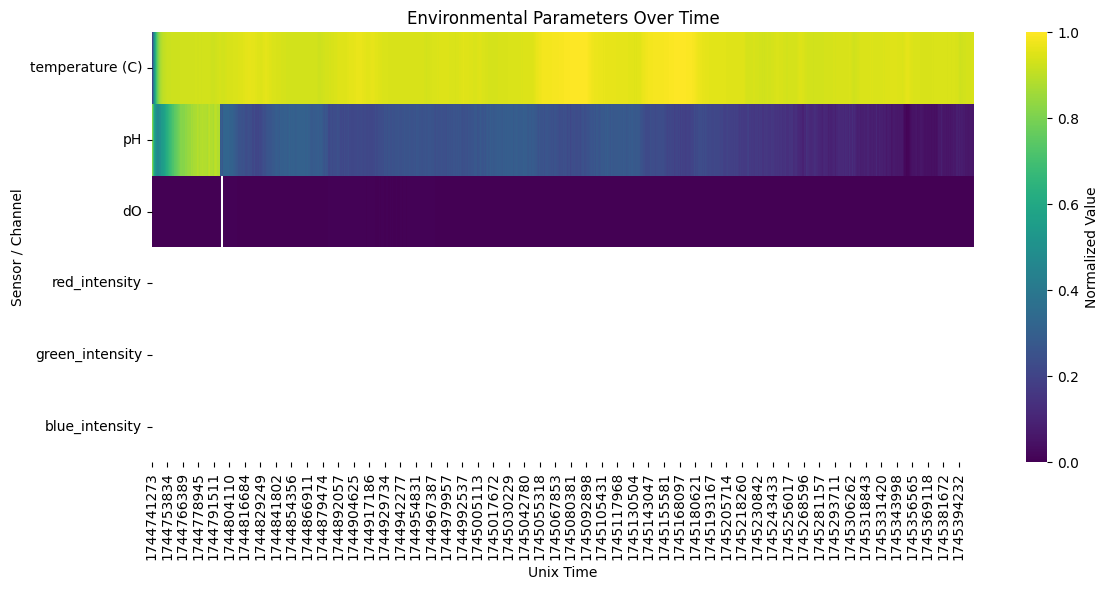

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_combined[
    [
        'unixtime',
        "temperature (C)",
        "pH",
        "dO",
        "red_intensity",
        "green_intensity",
        "blue_intensity",
    ]
]
heatmap_data = heatmap_data.dropna(how="all")
heatmap_data = heatmap_data.set_index("unixtime")
normalized = (heatmap_data - heatmap_data.min()) / (
    heatmap_data.max() - heatmap_data.min()
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized.transpose(), cmap="viridis", cbar_kws={"label": "Normalized Value"}
)
plt.xlabel("Unix Time")
plt.ylabel("Sensor / Channel")
plt.title("Environmental Parameters Over Time")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract the same data as before
lineplot_data = df_combined[
    [
        'unixtime',
        "temperature (C)",
        "pH",
        "dO",
        "red_intensity",
        "green_intensity",
        "blue_intensity",
    ]
]
lineplot_data = lineplot_data.dropna(how="all")
# Convert unixtime to datetime for better x-axis labels
lineplot_data['datetime'] = pd.to_datetime(lineplot_data['unixtime'], unit='s')
lineplot_data = lineplot_data.set_index('datetime')

# Normalize the data for consistent y-axis scale (optional)
# Comment these lines if you want to see actual values instead of normalized ones
normalized = (lineplot_data.drop(columns=['unixtime']) - lineplot_data.drop(columns=['unixtime']).min()) / (
    lineplot_data.drop(columns=['unixtime']).max() - lineplot_data.drop(columns=['unixtime']).min()
)

# Create a better color palette for distinguishing between lines
palette = sns.color_palette("husl", len(normalized.columns))

# Create the plot
plt.figure(figsize=(14, 8))

# Using a Seaborn lineplot for better aesthetics
ax = sns.lineplot(
    data=normalized,
    palette=palette,
    linewidth=2,
    dashes=False,
)

# Add better formatting
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Environmental Parameters Over Time', fontsize=16)

# Improve x-axis date formatting
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend with better positioning
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.grid(True, alpha=0.3)
plt.show()

# ALTERNATIVE VERSION: Non-normalized with multiple y-axes (uncomment to use)
'''
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Dictionary to store axes for different parameters
axes = {
    "temperature (C)": ax1,
    "pH": ax1.twinx(),
    "dO": ax1.twinx(),
}

# Create additional axes for color intensities
# Offset these axes to the right
axes["red_intensity"] = ax1.twinx()
axes["green_intensity"] = ax1.twinx()
axes["blue_intensity"] = ax1.twinx()

# Offset the additional y-axes
offset = 0
for i, ax_name in enumerate(["dO", "red_intensity", "green_intensity", "blue_intensity"]):
    offset += 60
    axes[ax_name].spines["right"].set_position(("outward", offset))

# Define colors for each parameter
colors = {
    "temperature (C)": "red",
    "pH": "blue",
    "dO": "green",
    "red_intensity": "darkred",
    "green_intensity": "darkgreen",
    "blue_intensity": "darkblue",
}

# Plot each parameter
for param in lineplot_data.drop(columns=['unixtime']).columns:
    axes[param].plot(
        lineplot_data.index, 
        lineplot_data[param], 
        color=colors[param], 
        label=param,
        linewidth=2
    )
    axes[param].set_ylabel(param, color=colors[param])
    axes[param].tick_params(axis='y', colors=colors[param])

# Format the plot
ax1.set_xlabel('Time')
ax1.set_title('Environmental Parameters Over Time (Actual Values)')
ax1.grid(True, alpha=0.3)

# Format x-axis dates
fig.autofmt_xdate()

# Create a combined legend
lines = []
labels = []
for param, ax in axes.items():
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()
'''

# If you want to resample to reduce data points for a smoother plot (uncomment to use)
'''
# Resample to 1-hour intervals
resampled_data = lineplot_data.drop(columns=['unixtime']).resample('1H').mean()

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=resampled_data,
    palette=palette,
    linewidth=2,
)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Environmental Parameters Over Time (Hourly Resampled)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()
'''


# Fun little exercise to try and look thru only the columns that have complete data for correlation matrix

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the columns we're interested in
correlation_data = df_combined[
    [
        "temperature (C)",
        "pH",
        "dO",
        "red_intensity",
        "green_intensity",
        "blue_intensity",
    ]
]

# Drop rows with any missing values
complete_data = correlation_data.dropna(how="any")
complete_data


,temperature (C),pH,dO,red_intensity,green_intensity,blue_intensity
417229,13.57,7.334,0.00,32842.0,18467.0,24659.0
420984,24.84,7.195,0.00,33161.0,18719.0,24920.0
424749,27.86,7.205,0.00,33288.0,18816.0,25032.0
428512,28.52,7.227,0.00,33498.0,18952.0,25197.0
432274,28.68,7.250,0.00,33619.0,19065.0,25331.0
...,...,...,...,...,...,...
1094514,29.04,7.065,0.00,18860.0,9171.0,13713.0
1098272,28.77,7.070,0.00,18798.0,9115.0,13652.0
1102024,28.85,7.066,0.00,18859.0,9150.0,13717.0
1105779,28.91,7.061,0.00,18827.0,9129.0,13697.0


Original shape: (693029, 6), After dropping NAs: (193, 6)


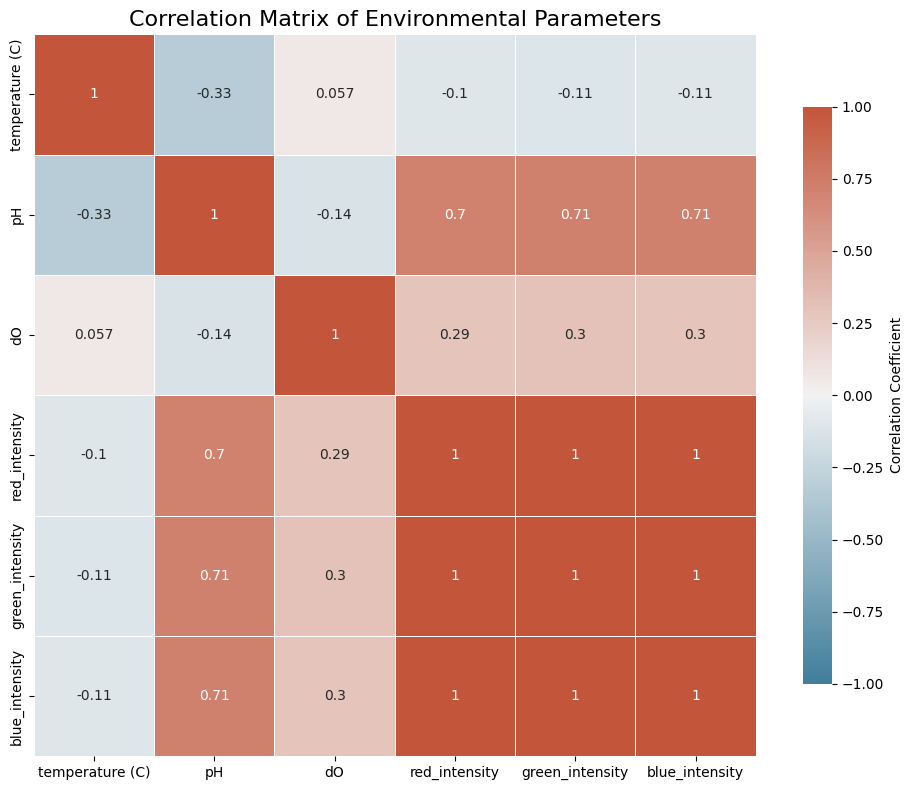


Correlation Matrix:
                 temperature (C)    pH    dO  red_intensity  green_intensity  \
temperature (C)             1.00 -0.33  0.06          -0.10            -0.11   
pH                         -0.33  1.00 -0.14           0.70             0.71   
dO                          0.06 -0.14  1.00           0.29             0.30   
red_intensity              -0.10  0.70  0.29           1.00             1.00   
green_intensity            -0.11  0.71  0.30           1.00             1.00   
blue_intensity             -0.11  0.71  0.30           1.00             1.00   

                 blue_intensity  
temperature (C)           -0.11  
pH                         0.71  
dO                         0.30  
red_intensity              1.00  
green_intensity            1.00  
blue_intensity             1.00  

Descriptive Statistics:
       temperature (C)          pH          dO  red_intensity  \
count       193.000000  193.000000  193.000000     193.000000   
mean         29.060052   

<Figure size 1200x1000 with 0 Axes>

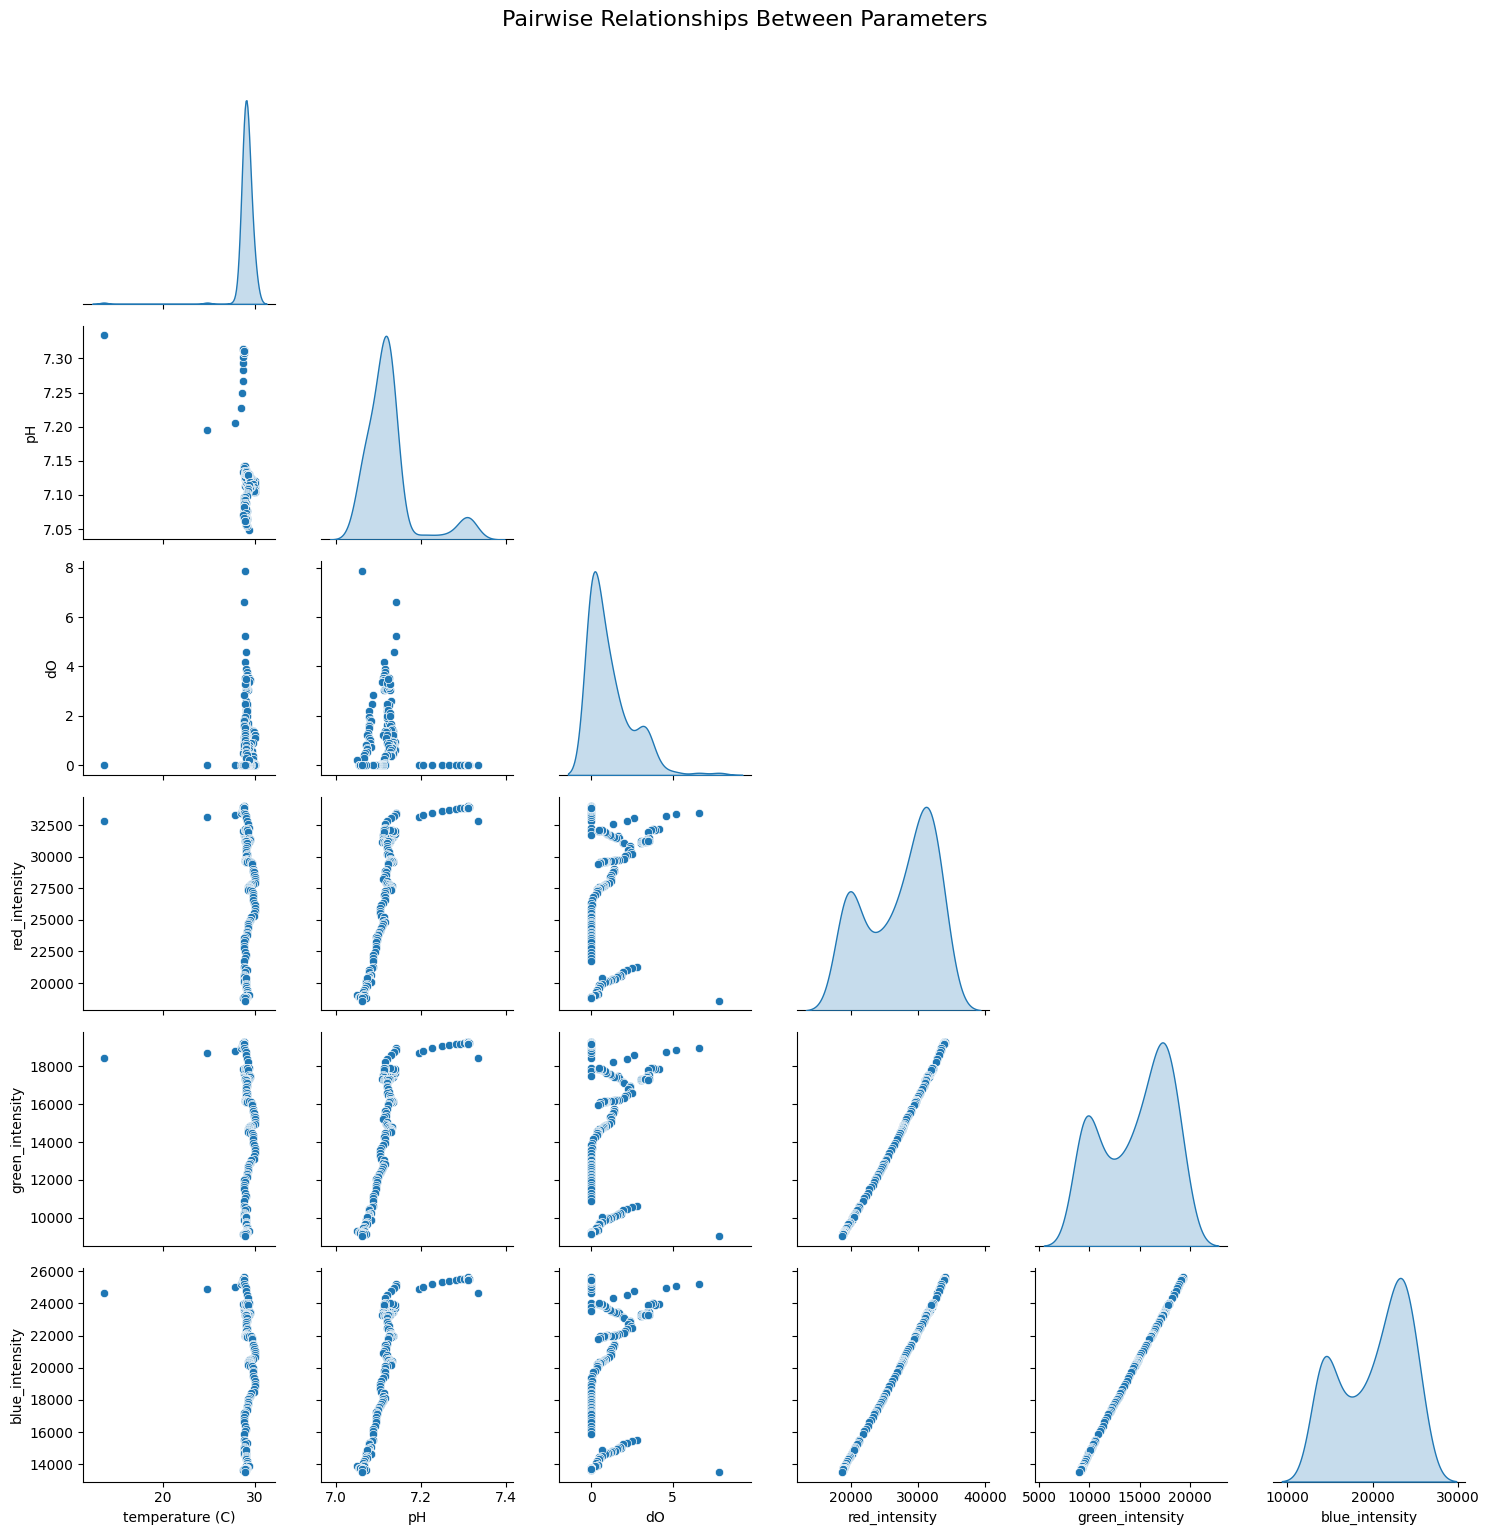

In [44]:
print(f"Original shape: {correlation_data.shape}, After dropping NAs: {complete_data.shape}")

# Calculate the correlation matrix
corr_matrix = complete_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with formatting
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Use a diverging colormap

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values
    cmap=cmap,   # Use our defined colormap
    vmax=1.0,    # Maximum correlation value
    vmin=-1.0,   # Minimum correlation value
    center=0,    # Center the colormap at zero
    square=True, # Make the cells square
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
)

plt.title('Correlation Matrix of Environmental Parameters', fontsize=16)
plt.tight_layout()
plt.show()

# Let's also look at the actual correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Additional analysis: descriptive statistics of complete data
print("\nDescriptive Statistics:")
print(complete_data.describe())

# You could also do a pairplot to see both distributions and correlations
plt.figure(figsize=(12, 10))
sns.pairplot(complete_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()